# Execute 2 nodes parallely side by side at a same time.

## Basic FLow : 1

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGCHAIN_TRACING_V2=True
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"

os.environ["LANGCHAIN_ENDPOINT"] =LANGCHAIN_ENDPOINT
os.environ["LANGCHAIN_PROJECT"] =LANGCHAIN_PROJECT
os.environ["LANGCHAIN_API_KEY"] =LANGCHAIN_API_KEY

# from langchain_google_genai import GoogleGenerativeAIEmbeddings
# from langchain_google_genai import ChatGoogleGenerativeAI

# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [2]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph, END

In [7]:
class State(TypedDict):
    aggregate: Annotated[list,operator.add]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret
    
    def __call__(self, state: State) -> Any:
        import time
        time.sleep(2)
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate":[self._value]}


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

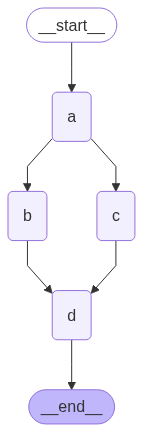

In [11]:
graph

In [8]:
graph.get_graph().draw_mermaid_png(output_file_path="async_graph.png")

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x8f\x00\x00\x01\xb0\x08\x02\x00\x00\x00\x1fZ\xa1\x08\x00\x00\x10\x00IDATx\x9c\xec\x9d\x07x\x14\xd5\xda\x80\xbf\xed-\x9bM\x0fI \t\x10CI\x02\x04\x08\x1d\x02BD\x08%\x80"\x02\x16\xc4.\xd2\xbcW\x05\x15\x05\x7fQ/X\xfe\x07\xb9(^\xaf\x15\xa5\t\x82@\xa2(U\x02$\x01\x92\x10@j\x12Jz\xdf\xde\xff\x0fr\x9f\xc8\xaf!\xac\xde\x99\xd99\xb3\xe7}x\xf6\x99\x9d\xd9,\xb3\xe7\x9ds\xcew\xca\x9c\x91\xba\xddn\xa0\x10\x82\x14(\xe4@m\x91\x04\xb5E\x12\xd4\x16IP[$Am\x91\x84\xd7lU^\xb6\x98\xf4N\x93\xde\xe1\xb0\xb9\xadf\x17\xf0\x1e\x99\\$\x91\x8a\xd4Z\xa9Z+\t\x89\x92\xcb\x95\x12\xe0\x1c\x11\xc7\xed\xad\x0b\x05\x86\xe2\x93\xc6KE\x86\x98nj\xf4\x84?>\xb0\x9d\xdcn!\xc1\x96B\xd4T\xe7\xc0\xcb\x0b/\xb2\x86*{P;y\xa7DM|\x1f?\x95\x1fwW<w\xb6\xce\x1d\xd7g\x7f_\x1b\x15\xa7\xea\xd0E\xd5)\xd1O\xae\x14\x03\xc9\\=o\xbaTd\xac\xbeb\x8d\xe8\xa8\x1c4>\x048\x81\x0b[\xc6&\xc7\x8f_Vb\x012h|\xb06P\x06\xc2\xe2\xd8\xcf\xf5\x87w\xd4\x8e\x9c\x1e\xd6-\xc5\x1fX\x86u[\x97\x7f5\xfd\xf4ue\xc6\xd3\x91A\

In [9]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id":"foo"}})

Adding I'm A to []
Adding I'm C to ["I'm A"]Adding I'm B to ["I'm A"]

Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Basic FLow : 2

In [14]:
builder_2 = StateGraph(State)
builder_2.add_node("a", ReturnNodeValue("I'm A"))
builder_2.add_node("b", ReturnNodeValue("I'm B"))
builder_2.add_node("b2", ReturnNodeValue("I'm B2"))
builder_2.add_node("c", ReturnNodeValue("I'm C"))
builder_2.add_node("d", ReturnNodeValue("I'm D"))

builder_2.add_edge(START, "a")
builder_2.add_edge("a", "b")
builder_2.add_edge("a", "c")
builder_2.add_edge("b", "b2")
builder_2.add_edge(["b2","c"], "d")
builder_2.add_edge("d", END)

graph = builder_2.compile()

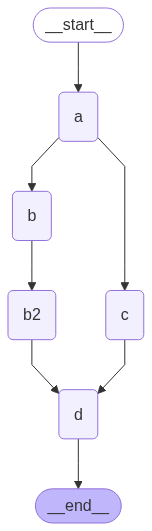

In [15]:
graph

In [16]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id":"foo"}})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Conditional Branching with async flow

In [ ]:
class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    which : str


def route_bc_or_cd(state: State):
    # Eithre cd will run parallel or bc will run parallel based on which value.
    if state["which"] == "cd":
        return ["c","d"]
    return ["b","c"]

intermediates = ["b","c","d"]

builder_3 = StateGraph(State)

builder_3.add_node("a", ReturnNodeValue("I'm A"))
builder_3.add_node("b", ReturnNodeValue("I'm B"))
builder_3.add_node("c", ReturnNodeValue("I'm C"))
builder_3.add_node("d", ReturnNodeValue("I'm D"))
builder_3.add_node("e", ReturnNodeValue("I'm E"))

builder_3.add_edge(START, "a")
builder_3.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates
)

for node in intermediates:
    builder_3.add_edge(node, "e")
builder_3.add_edge("e", END)
graph = builder_3.compile()

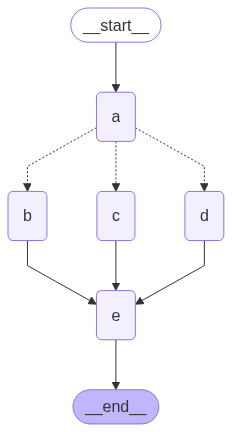

In [19]:
graph

In [20]:
graph.invoke({"aggregate": [],"which":""}, {"configurable": {"thread_id":"foo"}})

Adding I'm A to []
Adding I'm C to ["I'm A"]Adding I'm B to ["I'm A"]

Adding I'm E to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm E"], 'which': ''}

In [21]:
graph.invoke({"aggregate": [],"which":"cd"}, {"configurable": {"thread_id":"foo"}})

Adding I'm A to []
Adding I'm C to ["I'm A"]Adding I'm D to ["I'm A"]

Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}